# Introduction
The last few posts have used OSM extensively. In this post, I consider other rich sources of spatial data. Since I'm a kiwi who's interested in public sector work, I'm using spatial data available from NZ sources including StatsNZ and LINZ (Land Information New Zealand). 

The key analysis of this notebook is how to _combine_ and _aggregate_ spatial data. In brief, the notebook covers:
- Loading spatial boundary files and polygons from StatsNZ and LINZ
- Reshaping polygon data to administrative boundaries
- Aggregating metrics within administrative boundaries with (1) polygon data, and (2) point data

The above techniques are foundational for a couple of spatial modelling analyses:
- [Bayesian analysis of accessibility to amenities (e.g. playgrounds) within a spatial unit: suburb / meshblock](https://shriv.github.io/Playgrounds-vs-pubs/)
- Using the character of a spatial unit to model commuter flows in Wellington where the spatial unit characteristic is a continuum of residential area fraction. I started out following the [excellent tutorial by Adam Dennett for modelling commuting patterns](https://rpubs.com/adam_dennett/376877). [The preliminary hacked out an equivalent in R for Wellington City commuters](https://github.com/shriv/wellington-commutes) gave abysmal results because the data features were useless. 

In [1]:
# Import some packages
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas 
from shapely.geometry import Point, Polygon

# User modules
import utils.data_processing as dp

# Some configs
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
#%matplotlib inline

/home/shrividya/anaconda2/envs/spatial/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/shrividya/anaconda2/envs/spatial/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/shrividya/anaconda2/envs/spatial/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Administrative boundaries

In [2]:
# Load ESRI GDB boundary files at two levels: area units; meshblock
nz_mesh = geopandas.read_file('data/meshblock-2013/meshblock-2013.gdb/')
nz_area_unit = geopandas.read_file('data/area-unit-2013/area-unit-2013.gdb/')

## Plot administrative boundaries

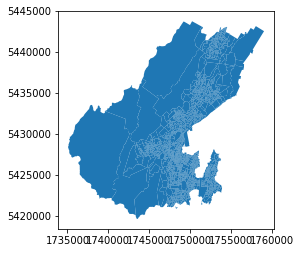

In [3]:
# Filter meshblocks by Wellington City TA
wlg_mesh = nz_mesh.query('TLAName == "Wellington City"')
wlg_mesh.plot()

In [4]:
wlg_mesh.head(1)

,Meshblock,MeshblockNumber,AreaUnitCode,AreaUnitName,UrbanAreaCode,UrbanAreaType,UrbanAreaName,TLACode,TLAName,WardCode,...,GeneralElectoralDistrictCode_2007,GeneralElectoralDistrictName_2007,MaoriElectoralDistrictCode_2007,MaoriElectoralDistrictName_2007,LandCode,LandDescription,LandAreaSQKM,Meshblock_1,Shape_Length,geometry
122,MB 2122500,2122500,572900,Thorndon-Tinakori Road,020,Main Urban Area,Wellington Zone,047,Wellington City,04703,...,059,Wellington Central,6,Te Tai Tonga,12,Mainland,0.015541,None,530.616904,"(POLYGON ((1749065.252999783 5428962.056200027, 1749061.018700123 5428875.665100098, 1748881.197700024 5428884.958099842, 1748885.959199905 5428956.5479002, 1748888.268199921 5428971.448599815, 1748958.335499763 5428967.979100227, 1748974.556000233 5428967.045199871, 1749065.252999783 5428962.056200027)))"


# Filter or dissolve spatial boundaries

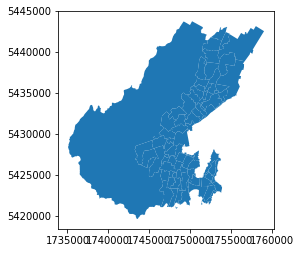

In [5]:
# Spatial area units in SA2 data
wlg_area_units = nz_area_unit[nz_area_unit['AU2013_V1_00_NAME'].isin(wlg_mesh['AreaUnitName'].unique())]
wlg_area_units.plot()

## Dissolve

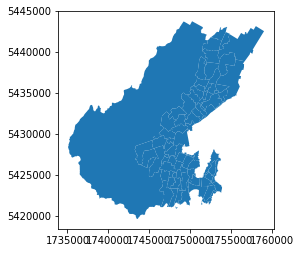

In [6]:
wlg_area_unit_from_mesh = wlg_mesh.dissolve(by='AreaUnitName')
wlg_area_unit_from_mesh.plot()

# Filtering with other spatial data

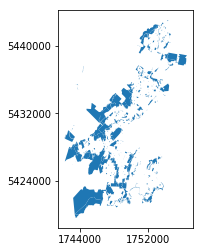

In [7]:
wcc_parks = geopandas.read_file('zip://./data/WCC_Parks_and_Reserves.zip')
wcc_parks_proj = wcc_parks.to_crs(wlg_area_units.crs)
wcc_parks_proj.plot()
dp.pretty_ticks(2, 4)

In [8]:
urban_wlg_area_units = geopandas.overlay(wlg_area_units, wcc_parks_proj, how='difference')
urban_wlg_area_units.shape

(79, 6)

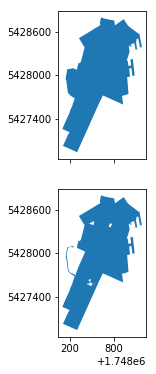

In [9]:
dp.plot_unit_residential(wlg_area_units, urban_wlg_area_units, 'Lambton')
dp.pretty_ticks(2, 4)


# LINZ datasets

In [10]:
nz_residential_linz = geopandas.read_file('data/residential-area/nz-residential-area-polygons-topo-150k.gdb')
nz_buildings_linz = geopandas.read_file('data/buildings/nz-building-polygons-topo-150k.gdb')

In [11]:
wlg_residential_linz = nz_residential_linz[(nz_residential_linz['name'] == 'Wellington') | 
                                          (nz_residential_linz['name'] == 'Makara') |
                                          (nz_residential_linz['name'] == 'Porirua') | 
                                          (nz_residential_linz['name'] == 'Lower Hutt')]

## Aggregating LINZ data at SA2 level

In [12]:
linz_wgtn = geopandas.overlay(wlg_area_units, wlg_residential_linz, how='intersection')
bldgs_wgtn = geopandas.overlay(wlg_area_units, nz_buildings_linz, how='intersection')

In [13]:
parks_wgtn = geopandas.overlay(wlg_area_units, wcc_parks_proj, how='intersection')

In [14]:
print('Raw LINZ columns:\n', wlg_residential_linz.columns, '\n')
print('Overlaid LINZ data:\n', linz_wgtn.columns)


Raw LINZ columns:
 Index(['t50_fid', 'name_ascii', 'macronated', 'name', 'geometry'], dtype='object') 

Overlaid LINZ data:
 Index(['AU2013_V1_00', 'AU2013_V1_00_NAME', 'AREA_SQ_KM', 'LAND_AREA_SQ_KM',
       'Shape_Length', 't50_fid', 'name_ascii', 'macronated', 'name',
       'geometry'],
      dtype='object')


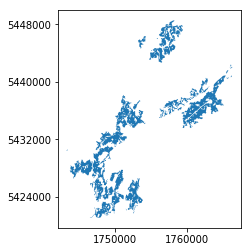

In [15]:
wlg_residential_linz.plot()
dp.pretty_ticks(2, 4)

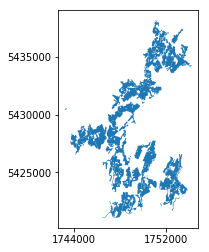

In [16]:
linz_wgtn.plot()
dp.pretty_ticks(2, 4)

## Aggregating LINZ data at meshblock level

In [17]:
linz_wgtn_mesh = geopandas.overlay(wlg_mesh, wlg_residential_linz, how='intersection')
bldgs_wgtn_mesh = geopandas.overlay(wlg_mesh, nz_buildings_linz, how='intersection')

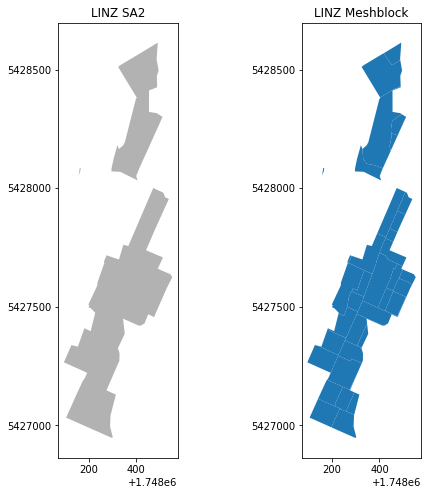

In [18]:

plt.figure(figsize=(8,8))
ax1 = plt.subplot(121)
linz_wgtn[linz_wgtn['AU2013_V1_00_NAME'] == "Lambton"].plot(ax=ax1, color='k', alpha=0.3)
ax1.set_aspect("equal")
ax1.set_title('LINZ SA2');

ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
linz_wgtn_mesh[linz_wgtn_mesh['AreaUnitName'] == 'Lambton'].plot(ax=ax2)
#ax1.set_xlim(1748000,1749500)
ax2.set_aspect("equal")
ax2.set_title('LINZ Meshblock');

dp.pretty_ticks(3, 4)

# Plotting spatial attributes

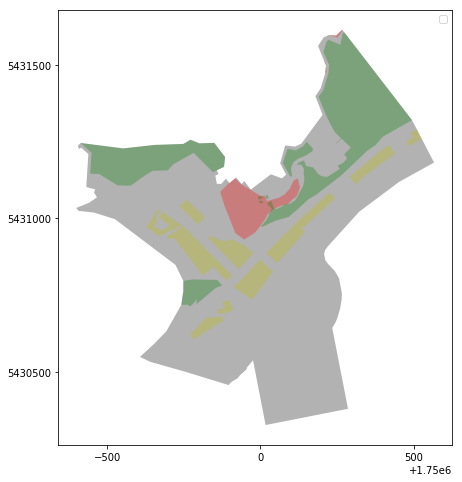

In [19]:
# plot set up
area_unit_name = 'Kaiwharawhara'
plt.figure(figsize=(20,8))
ax = plt.gca()

# Plot spatial data
wlg_area_units.query('AU2013_V1_00_NAME == @area_unit_name').plot(ax = ax, color='k', alpha=0.3)
bldgs_wgtn.query('AU2013_V1_00_NAME == @area_unit_name').plot(ax = ax, color='y', alpha=0.3)
linz_wgtn.query('AU2013_V1_00_NAME == @area_unit_name').plot(ax = ax, color='r', alpha=0.3)
parks_wgtn.query('AU2013_V1_00_NAME == @area_unit_name').plot(ax = ax, color='g', alpha=0.3)

# Pretty plot
dp.pretty_ticks(3, 3)

# Adding legend? Still not working..
plt.legend(["Area", "Buildings", "Residential"], loc='best')
plt.show()

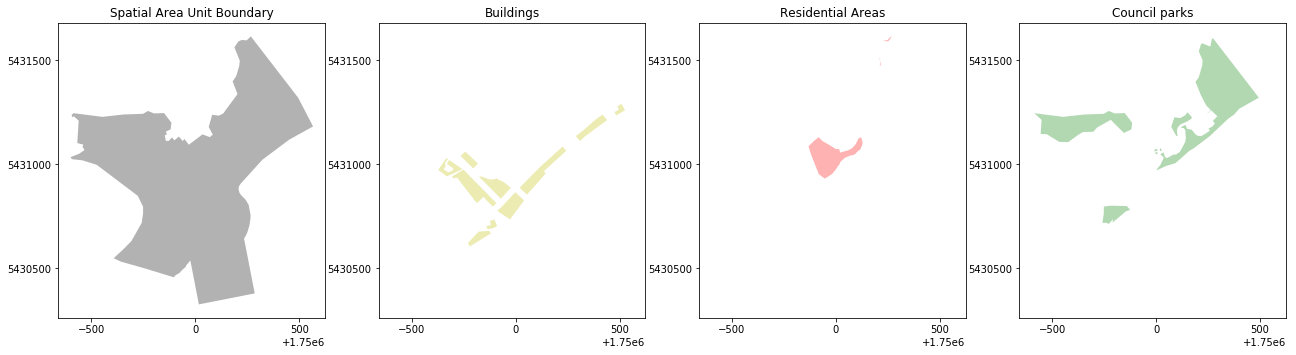

In [20]:
plt.figure(figsize=(22,8))
dp.plot_all(wlg_area_units, bldgs_wgtn, linz_wgtn, parks_wgtn, area_unit_name)
dp.pretty_ticks(3,3)

# Metrics by spatial area unit

In [21]:
linz_wgtn['residential_area'] = linz_wgtn['geometry'].area / 10**6
bldgs_wgtn['urban_area'] = bldgs_wgtn['geometry'].area / 10**6

residential_area_linz = (linz_wgtn
                        .groupby(['AU2013_V1_00_NAME'])
                        .agg({'residential_area': 'sum'})
                        .reset_index())

buildings_area_linz = (bldgs_wgtn
                        .groupby(['AU2013_V1_00_NAME'])
                        .agg({'urban_area': 'sum'})
                        .reset_index())

all_area_linz = pd.merge(residential_area_linz, buildings_area_linz)
all_area_linz['residential_area_frac'] = all_area_linz['residential_area'] / (all_area_linz['urban_area'] + all_area_linz['residential_area'])
all_area_linz.sort_values(['residential_area_frac'], ascending=False).sort_values(['residential_area'], ascending=False).query('residential_area_frac > 0.9').head(10)

,AU2013_V1_00_NAME,residential_area,urban_area,residential_area_frac
19,Karori Park,1.117128,0.007709,0.993146
53,Te Kainga,1.106857,0.015128,0.986517
20,Karori South,1.068438,0.002446,0.997716
17,Karori East,0.945213,0.022765,0.976482
37,Newlands South,0.922107,0.020225,0.978537
9,Hataitai North,0.895948,0.030002,0.967598
52,Strathmore Park,0.878239,0.018258,0.979634
48,Raroa,0.847359,0.047532,0.946885
40,Ngaio South,0.845334,0.008818,0.989676
3,Brooklyn,0.826322,0.031779,0.962966


In [26]:
all_area_linz.sort_values(['residential_area_frac'], ascending=True).sort_values(['urban_area'], ascending=False).query('residential_area_frac < 0.5').head(10)

,AU2013_V1_00_NAME,residential_area,urban_area,residential_area_frac
55,Willis Street-Cambridge Terrace,0.012446,0.816003,0.015023
26,Lambton,0.234194,0.439452,0.347651
54,Thorndon-Tinakori Road,0.376552,0.439250,0.461572
0,Adelaide,0.026478,0.158613,0.143054
42,Ngauranga West,0.003520,0.088027,0.038452
15,Kaiwharawhara,0.023300,0.053428,0.303672
41,Ngauranga East,0.000245,0.040628,0.006002
28,Makara-Ohariu,0.013893,0.016887,0.451357
